In [1]:
# Copyright 2022 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# From ETL to Training RecSys models - NVTabular and Merlin Models integrated example

## Overview

In [01-Getting-started.ipynb](01-Getting-started.ipynb), we provide a getting started example to train a DLRM model on the MovieLens 1M dataset. In this notebook, we will explore how Merlin Models uses the ETL output from [NVTabular](https://github.com/NVIDIA-Merlin/NVTabular/).<br><br>

### Learning objectives

This notebook provides details on how NVTabular and Merlin Models are linked together. We will discuss the concept of the `schema` file.

## Merlin

[Merlin](https://developer.nvidia.com/nvidia-merlin) is an open-source framework for building large-scale (deep learning) recommender systems. It is designed to support recommender systems end-to-end from ETL to training to deployment on CPU or GPU. Common deep learning frameworks are integrated such as TensorFlow (and PyTorch in the future). Among its key benefits are the easy-to-use and flexible APIs, availability of popular recsys architectures, accelerated training and evaluation with GPU and scaling to multi-GPU or multi-node systems.

Merlin Models and NVTabular are components of Merlin. They are designed to work closely together. 

[Merlin Models](https://github.com/NVIDIA-Merlin/models/) is a library to make it easy for users in industry or academia to train and deploy recommender models with best practices baked into the library. Data Scientists and ML Engineers can easily train standard and state-of-the art models on their own dataset, getting high performance GPU accelerated models into production. Researchers can build custom models by incorporating standard components of deep learning recommender models and benchmark their new models on example offline datasets.

[NVTabular](https://github.com/NVIDIA-Merlin/NVTabular/) is a feature engineering and preprocessing library for tabular data that is designed to easily manipulate terabyte scale datasets and train deep learning (DL) based recommender systems. It provides high-level abstraction to simplify code and accelerates computation on the GPU using the RAPIDS Dask-cuDF library under the hood.

## Integration of NVTabular and Merlin Models

<img src="images/schema.png">

In this notebook, we focus on an important piece of an ML pipeline: feature engineering and model training.

If you use NVTabular for feature engineering, NVTabular will output (in addition to the preprocessed parquet files), a **schema** file describing the dataset structures. The schema contains columns statistics, tags and metadata collected by NVTabular. Here are some examples of such metadata computed by some NVTabular preprocessing ops:

- **Categorify:** This op transforms categorical columns into contiguous integers (`0, ..., |C|`) for embedding layers. The columns that are processed by this op have save in the schema its cardinality `|C|` and are also tagged as **CATEGORICAL**.
- **Normalize**: This op applies standardization to normalize continuous features. The mean and stddev of the columns are saved to the schema, also being tagged as **CONTINUOUS**.

The users can also define their own tags in the preprocessing pipeline to group together related features, for further modeling purposes.

**Let's take a look on the MovieLens 1M example.**

In [1]:
import pandas as pd

import nvtabular as nvt
from nvtabular import ops as nvt_ops

import merlin.models.tf as mm
from merlin.models.utils import example_utils
from merlin.datasets.entertainment import get_movielens, get_movielens_raw
from merlin.schema import Tags

2022-04-06 16:08:23.001380: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-06 16:08:24.475442: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 24342 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-04-06 16:08:24.476890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46347 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:21:00.0, compute capability: 8.6


We will use the utils function to download, extract and preprocess the dataset.

In [16]:
train, valid = get_movielens(variant="ml-1m")
schema = train.schema

2022-04-06 16:17:13.490721: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 24342 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-04-06 16:17:13.491897: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 46347 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:21:00.0, compute capability: 8.6


P.s. You can also choose to generate synthetic data to test your models using `generate_data()`. The `input` argument can be either the name of one of the supported public datasets (e.g. "movielens-1m", "criteo") or the schema of a dataset (which is explained next). For example:

```python
from merlin.datasets.synthetic import generate_data
train, valid = generate_data(input="movielens-1m", num_rows=1000000, set_sizes=(0.8, 0.2))
```

## Understanding the Schema File and Structure

When NVTabular process the data, it will persist the schema as a file to disk. You can access the `schema` from the Merlin `Dataset` class (like below).

The `schema` can be interpreted as a list of features in the dataset, where each element describes metadata of the feature. It contains the name, some properties (e.g. statistics) depending on the feature type and multiple tags. 

In [18]:
schema

,name,tags,dtype,is_list,is_ragged,properties.freq_threshold,properties.max_size,properties.cat_path,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.num_buckets,properties.start_index,properties.domain.min,properties.domain.max,properties.value_count.min,properties.value_count.max
0,userId,"(Tags.USER, Tags.CATEGORICAL, Tags.USER_ID)",int32,False,False,0.0,0.0,.//categories/unique.userId.parquet,6041.0,210.0,NaN,0.0,0.0,6041.0,NaN,NaN
1,movieId,"(Tags.ITEM_ID, Tags.CATEGORICAL, Tags.ITEM)",int32,False,False,0.0,0.0,.//categories/unique.movieId.parquet,3685.0,159.0,NaN,0.0,0.0,3685.0,NaN,NaN
2,title,(Tags.CATEGORICAL),int32,False,False,0.0,0.0,.//categories/unique.title.parquet,3685.0,159.0,NaN,0.0,0.0,3685.0,NaN,NaN
3,genres,"(Tags.ITEM, Tags.CATEGORICAL)",int32,True,True,0.0,0.0,.//categories/unique.genres.parquet,19.0,16.0,NaN,0.0,0.0,19.0,1.0,6.0
4,gender,(Tags.CATEGORICAL),int32,False,False,0.0,0.0,.//categories/unique.gender.parquet,3.0,16.0,NaN,0.0,0.0,3.0,NaN,NaN
5,age,(Tags.CATEGORICAL),int32,False,False,0.0,0.0,.//categories/unique.age.parquet,8.0,16.0,NaN,0.0,0.0,8.0,NaN,NaN
6,occupation,(Tags.CATEGORICAL),int32,False,False,0.0,0.0,.//categories/unique.occupation.parquet,22.0,16.0,NaN,0.0,0.0,22.0,NaN,NaN
7,zipcode,(Tags.CATEGORICAL),int32,False,False,0.0,0.0,.//categories/unique.zipcode.parquet,3440.0,153.0,NaN,0.0,0.0,3440.0,NaN,NaN
8,TE_age_rating,"(Tags.USER, Tags.CONTINUOUS)",float32,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,TE_gender_rating,"(Tags.USER, Tags.CONTINUOUS)",float32,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can select the features by **name**.

In [19]:
schema.select_by_name("userId")

,name,tags,dtype,is_list,is_ragged,properties.freq_threshold,properties.max_size,properties.cat_path,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.num_buckets,properties.start_index,properties.domain.min,properties.domain.max
0,userId,"(Tags.USER, Tags.CATEGORICAL, Tags.USER_ID)",int32,False,False,0.0,0.0,.//categories/unique.userId.parquet,6041.0,210.0,None,0.0,0,6041


We can also select features by **tags**. As we described earlier in the notebook, categorical and continuous features are automatically tagged when using ops like `Categorify()` and `Normalize()`.
In our example preprocessing workflow for this dataset, we also set the `Tags` for the the `user` and `item` features, and also for the `user_id` and `item_id`, which are important for collaborative filtering architectures. 

Alternatively, we can select them by `Tag`. We add `column_names` to the object to receive only names without all the additional metadata.

In [20]:
# All categorical features
schema.select_by_tag(Tags.CATEGORICAL)

,name,tags,dtype,is_list,is_ragged,properties.freq_threshold,properties.max_size,properties.cat_path,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.num_buckets,properties.start_index,properties.domain.min,properties.domain.max,properties.value_count.min,properties.value_count.max
0,userId,"(Tags.USER, Tags.CATEGORICAL, Tags.USER_ID)",int32,False,False,0.0,0.0,.//categories/unique.userId.parquet,6041.0,210.0,None,0.0,0,6041,NaN,NaN
1,movieId,"(Tags.ITEM_ID, Tags.CATEGORICAL, Tags.ITEM)",int32,False,False,0.0,0.0,.//categories/unique.movieId.parquet,3685.0,159.0,None,0.0,0,3685,NaN,NaN
2,title,(Tags.CATEGORICAL),int32,False,False,0.0,0.0,.//categories/unique.title.parquet,3685.0,159.0,None,0.0,0,3685,NaN,NaN
3,genres,"(Tags.ITEM, Tags.CATEGORICAL)",int32,True,True,0.0,0.0,.//categories/unique.genres.parquet,19.0,16.0,None,0.0,0,19,1.0,6.0
4,gender,(Tags.CATEGORICAL),int32,False,False,0.0,0.0,.//categories/unique.gender.parquet,3.0,16.0,None,0.0,0,3,NaN,NaN
5,age,(Tags.CATEGORICAL),int32,False,False,0.0,0.0,.//categories/unique.age.parquet,8.0,16.0,None,0.0,0,8,NaN,NaN
6,occupation,(Tags.CATEGORICAL),int32,False,False,0.0,0.0,.//categories/unique.occupation.parquet,22.0,16.0,None,0.0,0,22,NaN,NaN
7,zipcode,(Tags.CATEGORICAL),int32,False,False,0.0,0.0,.//categories/unique.zipcode.parquet,3440.0,153.0,None,0.0,0,3440,NaN,NaN


In [21]:
# All continuous features
schema.select_by_tag(Tags.CONTINUOUS)

,name,tags,dtype,is_list,is_ragged
0,TE_age_rating,"(Tags.USER, Tags.CONTINUOUS)",float32,False,False
1,TE_gender_rating,"(Tags.USER, Tags.CONTINUOUS)",float32,False,False
2,TE_occupation_rating,"(Tags.USER, Tags.CONTINUOUS)",float32,False,False
3,TE_zipcode_rating,"(Tags.USER, Tags.CONTINUOUS)",float32,False,False
4,TE_movieId_rating,"(Tags.ITEM, Tags.CONTINUOUS)",float32,False,False
5,TE_userId_rating,"(Tags.USER, Tags.CONTINUOUS)",float32,False,False


In [22]:
# All targets
train.schema.select_by_tag(Tags.TARGET)

,name,tags,dtype,is_list,is_ragged
0,rating_binary,"(Tags.BINARY_CLASSIFICATION, Tags.TARGET)",int32,False,False
1,rating,"(Tags.TARGET, Tags.REGRESSION)",float32,False,False


In [23]:
# All features related to the item
train.schema.select_by_tag(Tags.ITEM)

,name,tags,dtype,is_list,is_ragged,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.num_buckets,properties.max_size,properties.freq_threshold,properties.cat_path,properties.start_index,properties.domain.min,properties.domain.max,properties.value_count.min,properties.value_count.max
0,movieId,"(Tags.ITEM_ID, Tags.CATEGORICAL, Tags.ITEM)",int32,False,False,3685.0,159.0,NaN,0.0,0.0,.//categories/unique.movieId.parquet,0.0,0.0,3685.0,NaN,NaN
1,genres,"(Tags.ITEM, Tags.CATEGORICAL)",int32,True,True,19.0,16.0,NaN,0.0,0.0,.//categories/unique.genres.parquet,0.0,0.0,19.0,1.0,6.0
2,TE_movieId_rating,"(Tags.ITEM, Tags.CONTINUOUS)",float32,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# The item id feature name
train.schema.select_by_tag(Tags.ITEM_ID)

,name,tags,dtype,is_list,is_ragged,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.num_buckets,properties.max_size,properties.freq_threshold,properties.cat_path,properties.start_index,properties.domain.min,properties.domain.max
0,movieId,"(Tags.ITEM_ID, Tags.CATEGORICAL, Tags.ITEM)",int32,False,False,3685.0,159.0,None,0.0,0.0,.//categories/unique.movieId.parquet,0.0,0,3685


In [25]:
# All features related to the user
train.schema.select_by_tag(Tags.USER)

,name,tags,dtype,is_list,is_ragged,properties.freq_threshold,properties.max_size,properties.cat_path,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.num_buckets,properties.start_index,properties.domain.min,properties.domain.max
0,userId,"(Tags.USER, Tags.CATEGORICAL, Tags.USER_ID)",int32,False,False,0.0,0.0,.//categories/unique.userId.parquet,6041.0,210.0,NaN,0.0,0.0,6041.0
1,TE_age_rating,"(Tags.USER, Tags.CONTINUOUS)",float32,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TE_gender_rating,"(Tags.USER, Tags.CONTINUOUS)",float32,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TE_occupation_rating,"(Tags.USER, Tags.CONTINUOUS)",float32,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TE_zipcode_rating,"(Tags.USER, Tags.CONTINUOUS)",float32,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,TE_userId_rating,"(Tags.USER, Tags.CONTINUOUS)",float32,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# The user id feature name
train.schema.select_by_tag(Tags.USER_ID)

,name,tags,dtype,is_list,is_ragged,properties.freq_threshold,properties.max_size,properties.cat_path,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.num_buckets,properties.start_index,properties.domain.min,properties.domain.max
0,userId,"(Tags.USER, Tags.CATEGORICAL, Tags.USER_ID)",int32,False,False,0.0,0.0,.//categories/unique.userId.parquet,6041.0,210.0,None,0.0,0,6041


We can also query all properties of a feature. Here we see that the cardinality (number of unique values) of the `movieId` feature is `3685`, which is an important information to build the corresponding embedding table.

In [28]:
train.schema.select_by_tag(Tags.ITEM_ID)

,name,tags,dtype,is_list,is_ragged,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.num_buckets,properties.max_size,properties.freq_threshold,properties.cat_path,properties.start_index,properties.domain.min,properties.domain.max
0,movieId,"(Tags.ITEM_ID, Tags.CATEGORICAL, Tags.ITEM)",int32,False,False,3685.0,159.0,None,0.0,0.0,.//categories/unique.movieId.parquet,0.0,0,3685


The `schema` is a great interface between feature engineering and modeling libraries, describing the available features and their metadata/statistics. It makes it easy to build generic models definition, as the features names and types are automatically inferred from schema and represented properly in the neural networks architectures. That means that when the dataset changes (e.g. features are added or removed), you don't have to change the modeling code to leverage the new dataset!

For example, the `DLRMModel` embeds categorical features and applies an MLP (called bottom MLP) to combine the continuous features. As another example, The `TwoTowerModel` (for retrieval) builds one MLP tower to combine user features and another MLP tower for the item features, factorizing both towers in the output.

## Integrated pipeline with NVTabular and Merlin Models

Now you have a solid understanding of the importance of the schema and how the schema works. 

The best way is to use [NVTabular](https://github.com/NVIDIA-Merlin/NVTabular/) for the feature engineering step, so that the schema file is automatically created for you. We will look on a minimal example for the MovieLens dataset.

### Download and prepare the data

We will download the dataset, if it is not already downloaded and cached locally.

In [29]:
path = get_movielens_raw(variant="ml-1m")

pd.read_parquet(str(path / "train.parquet")).head()

,userId,movieId,rating,timestamp
684396,4090,3035,5,965426000
145370,935,2320,3,975182770
158267,1015,2161,5,975036198
857259,5153,2054,3,961969091
413331,2485,1208,3,974144842


### Feature Engineering and Generating Schema File with NVTabular

We use NVTabular to define a preprocessing and feature engineering pipeline. 

NVTabular has already implemented multiple transformations, called `ops` that can be applied to a `ColumnGroup` from an overloaded `>>` operator.<br><br>
**Example:**<br>
```python
features = [ column_name, ...] >> op1 >> op2 >> ...
```

We need to perform following steps:
- Categorify userId and movieId, that the values are contiguous integers from 0 ... |C|
- Transform the rating column ([1,5] interval) to a binary target by using as threshold the value `3`
- Add Tags with `ops.AddMetadata` for `item_id`, `user_id`, `item`, `user` and `target`.

Categorify will transform categorical columns into contiguous integers (`0, ..., |C|`) for embedding layers. It collects the cardinality of the embedding table and tags it as categorical.

In [31]:
cat_features = ["userId", "movieId"] >> nvt_ops.Categorify(dtype="int32")

The tags for `user`, `userId`, `item` and `itemId` cannot be inferred from the dataset. Therefore, we need to provide them manually during the NVTabular workflow. Actually, the `DLRMModel` does not differentiate between `user` and `item` features. But other architectures, such as the `TwoTowerModel` depends on the `user` and `item` features distinction. We will show how to tag features manually in a NVTabular workflow below. 

In [32]:
feats_itemId = cat_features["movieId"] >> nvt_ops.TagAsItemID()
feats_userId = cat_features["userId"] >> nvt_ops.TagAsUserID()
feats_target = (
    nvt.ColumnSelector(["rating"])
    >> nvt_ops.LambdaOp(lambda col: (col > 3).astype("int32"))
    >> nvt_ops.AddTags(["binary_classification", "target"])
    >> nvt_ops.Rename(name="rating_binary")
)
output = feats_itemId + feats_userId + feats_target

We fit the workflow to our train set and apply to the valid and test sets.

In [33]:
%%time
train, valid = get_movielens(
    variant="ml-1m", nvt_workflow=output, overwrite=True, transformed_name="notebook"
)

2022-04-06 16:21:10.326596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 24342 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-04-06 16:21:10.327791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 46347 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:21:00.0, compute capability: 8.6
/home/marc/anaconda3/envs/models-22.02/lib/python3.8/site-packages/cudf/core/dataframe.py:1292: UserWarning: The deep parameter is ignored and is only included for pandas compatibility.
  warnings.warn(


CPU times: user 408 ms, sys: 223 ms, total: 630 ms
Wall time: 631 ms


### Training a Recommender Model with Merlin Models

We can load the data as a Merlin Dataset object. The Dataset expect the schema as Protobuf text format (`.pbtxt`) file in the train/valid folder, which NVTabular automatically generates.

We can see that the `schema` object contains the features tags and the cardinalities of the categorical features.
As we prepared only a minimal example, our schema has only tree features `movieId`, `userId` and `rating_binary`.|

In [34]:
train.schema

,name,tags,dtype,is_list,is_ragged,properties.cat_path,properties.start_index,properties.max_size,properties.freq_threshold,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.num_buckets,properties.domain.min,properties.domain.max
0,movieId,"(Tags.ITEM_ID, Tags.CATEGORICAL, Tags.ITEM)",int32,False,False,.//categories/unique.movieId.parquet,0.0,0.0,0.0,3685.0,159.0,NaN,0.0,3685.0
1,userId,"(Tags.USER, Tags.CATEGORICAL, Tags.USER_ID)",int32,False,False,.//categories/unique.userId.parquet,0.0,0.0,0.0,6041.0,210.0,NaN,0.0,6041.0
2,rating_binary,"(Tags.BINARY_CLASSIFICATION, Tags.TARGET)",int32,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here we create, train & evaluate our model. We use by default typical binary classification metrics -- Precision, Recall, Accuracy and AUC. But you also can provide your own metrics list by setting `BinaryClassificationTask(..., metrics=[])`.

Epoch 1/3
779/782 [============================>.] - ETA: 0s - target/precision: 0.7116 - target/recall: 0.8246 - target/binary_accuracy: 0.7069 - target/auc: 0.7687 - loss: 0.5625 - regularization_loss: 0.0000e+00 - total_loss: 0.5625

2022-04-06 13:18:57.109757: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/then/_0/cond/cond/branch_executed/_101


782/782 [==============================] - 6s 6ms/step - target/precision: 0.7117 - target/recall: 0.8245 - target/binary_accuracy: 0.7070 - target/auc: 0.7687 - loss: 0.5624 - regularization_loss: 0.0000e+00 - total_loss: 0.5624 - val_target/precision: 0.7396 - val_target/recall: 0.8091 - val_target/binary_accuracy: 0.7262 - val_target/auc: 0.7919 - val_loss: 0.5646 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.5646
Epoch 2/3
782/782 [==============================] - 4s 5ms/step - target/precision: 0.7389 - target/recall: 0.8228 - target/binary_accuracy: 0.7309 - target/auc: 0.7980 - loss: 0.5322 - regularization_loss: 0.0000e+00 - total_loss: 0.5322 - val_target/precision: 0.7313 - val_target/recall: 0.8374 - val_target/binary_accuracy: 0.7294 - val_target/auc: 0.7956 - val_loss: 0.5615 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.5615
Epoch 3/3
782/782 [==============================] - 4s 5ms/step - target/precision: 0.7434 - target/recall: 0.8252 - target

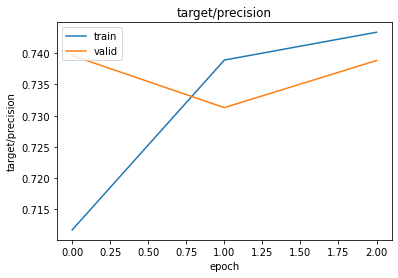

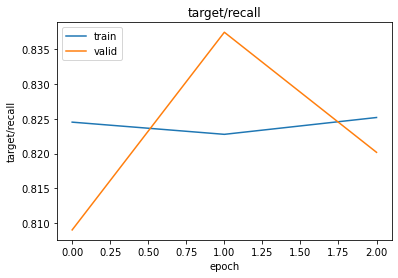

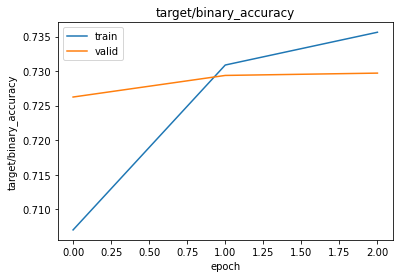

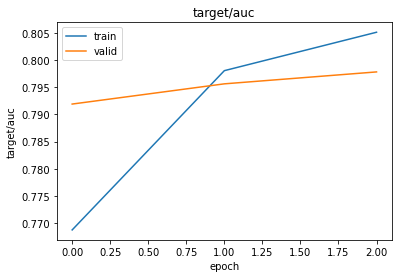

In [13]:
model = mm.DLRMModel(
    train.schema,
    embedding_dim=64,
    bottom_block=mm.MLPBlock([128, 64]),
    top_block=mm.MLPBlock([128, 64, 32]),
    prediction_tasks=mm.BinaryClassificationTask(train.schema, "target")
)
model.compile(optimizer="adam")
history = model.fit(train, validation_data=valid, batch_size=1024, epochs=3)

example_utils.plot_keras_history(history, add_loss=False)

The model automatically created all the necesairy embedding tables based on 
metadata from the schema

In [14]:
model.context.variables

[<tf.Variable 'model_2/sequential_block_23/movieId/embedding:0' shape=(3686, 64) dtype=float32, numpy=
 array([[ 0.04830761, -0.14133948, -0.06935223, ...,  0.14929162,
         -0.0903465 ,  0.11057409],
        [-0.01115329, -0.03024795, -0.12521659, ...,  0.08560898,
         -0.00853344,  0.04806389],
        [-0.19345513, -0.1259769 ,  0.04941146, ..., -0.22400218,
         -0.00256456,  0.07245155],
        ...,
        [-0.01271548, -0.09894037,  0.16752397, ...,  0.0418424 ,
          0.05052268,  0.28541055],
        [ 0.09665268, -0.01213991,  0.00888554, ..., -0.02214259,
         -0.06472962, -0.02675437],
        [ 0.24888732,  0.09954852,  0.01061598, ..., -0.01407822,
          0.14505954,  0.14845544]], dtype=float32)>,
 <tf.Variable 'model_2/sequential_block_23/userId/embedding:0' shape=(6042, 64) dtype=float32, numpy=
 array([[ 0.01974071,  0.07452961, -0.12815093, ..., -0.18776013,
         -0.01251517,  0.02414091],
        [-0.01589955, -0.01586955,  0.18668933, ..

## Conclusion

This example shows the easiness and flexibility provided by the integration between NVTabular and Merlin Models.
Feature engineering and model training are depending on each other. The `schema` object is a convenient way to provide information from the available features for dynamically setting the model definition. It allows for the modeling code to capture changes in the available features and avoids hardcoding feature names.

The dataset features are `tagged` automatically (and manually if needed) to group together features, for further modeling usage. 

The recommended practice is to use `NVTabular` for feature engineering, which generates a `schema` file. NVTabular can automatically add `Tags` for certrain operations. For example, the output of `Categorify` is always a categorical feature and will be tagged. Similar, the output of `Normalize` is always continuous. If you choose to use another preprocessing library, you can create the `schema` file manually, using either the Protobuf text format (`.pbtxt`) or `json` format.


## Next Steps

In the next notebooks, we will explore multiple ranking models with Merlin Models.

You can learn more about NVTabular, its functionality and supported ops by visiting our [github repository](https://github.com/NVIDIA-Merlin/NVTabular/) or exploring the [examples](https://github.com/NVIDIA-Merlin/NVTabular/tree/main/examples), such as [`Getting Started MovieLens`](https://github.com/NVIDIA-Merlin/NVTabular/blob/main/examples/getting-started-movielens/02-ETL-with-NVTabular.ipynb) or [`Scaling Criteo`](https://github.com/NVIDIA-Merlin/NVTabular/tree/main/examples/scaling-criteo).